In [181]:
import pandas as pd
import numpy as np
import os, json
import pandas as pd
import numpy as np
from datetime import datetime
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')
from speed_functions1 import * # -- seperate .py file 
import h5py
%load_ext autotime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,StandardScaler
from sklearn.cluster import AgglomerativeClustering
%timeit

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 148 ms


## Data Preprocessing ##

In [2]:
# || 2. Declare test data locations

H5=[]

A1=[]
A2=[]

Data_Loc = 'C:\Users\Home\Documents\Skill Corner Tracking\Structured Data Altered'

for filename_with_ext in os.listdir(Data_Loc):
    
    if (filename_with_ext.endswith(".h5")):  
        
        # get the file name without the extension
        filename = filename_with_ext.split('.')[0]
        H5.append(filename)
H5=H5[1:2]

for file in H5:

    ################  Reading the Tracking H5 File ####################### 

    tracking_file = r'C:\Users\Home\Documents\Skill Corner Tracking\Structured Data Altered/'+str(file)+'.h5'
    newlist = file.split('_')
    Home_Team=newlist[0]
    Away_Team=newlist[1]

    key='xy_data'
    tracking_df=pd.read_hdf(tracking_file,key)
    tracking_df['Time']=tracking_df['timestamp'].str.split(':').apply(lambda x: int(x[0])*60 +int(x[1])+float(x[2])/100)
    
    tracking_df=tracking_df.sort_values(by='Time',ascending=True)
    tracking_df=tracking_df.drop(['data','trackable_object_x','timestamp','image_corners_projection'],axis=1)
    tracking_df['z']=tracking_df['z'].fillna(0)
    tracking_df.track_id=tracking_df.track_id.astype(int)
    tracking_df = tracking_df.rename({'track_id': 'trackable_object'}, axis=1)

    
    ################  Reading the Match Data File ####################### 
    
    Match_data_file = r'C:\Users\Home\Documents\Skill Corner Tracking\Match Data Altered/'+str(file)+'.csv'
    
    Match_data_df=pd.read_csv(Match_data_file, usecols=lambda x: 'Unnamed: 0' not in x)
    Match_data_df=Match_data_df.loc[:, 'Full_Name':'team_name']
    
    ## Merge the two dataframes using the tracking object ids ##

    tracking_df=pd.merge(tracking_df,Match_data_df,on='trackable_object',how='left')
    
    tracking_df.position_name=tracking_df.position_name.fillna('Ball')
    tracking_df.Full_Name=tracking_df.Full_Name.fillna('Ball')
    tracking_df.team_name=tracking_df.team_name.fillna('Ball')
    tracking_df.team_player_id=tracking_df.team_player_id.fillna(0)
    tracking_df.player_id=tracking_df.player_id.fillna(0)
    tracking_df.position_id=tracking_df.position_id.fillna(0)
    tracking_df.jersey_number=tracking_df.jersey_number.fillna(0).astype(int)
    
    tracking_df['x']=np.where(tracking_df.period==2,tracking_df['x']*-1,tracking_df['x'])
    tracking_df['y']=np.where(tracking_df.period==2,tracking_df['y']*-1,tracking_df['y'])
    
    
    ### bringing them to similar scale as Pitch Measurements ##

    tracking_df['x1']=tracking_df['x']+52.5
    tracking_df['y1']=tracking_df['y']+35
    

    
    tracking_df['x1']=tracking_df['x1'].astype(int)
    tracking_df['y1']=tracking_df['y1'].astype(int)
    

    tracking_df['x1']=np.where(tracking_df['x1']<-5,-5,tracking_df['x1'])
    tracking_df['y1']=np.where(tracking_df['y1']<-5,-5,tracking_df['y1'])
    
    ### bringing them to similar scale as Wyscout Units ##
    
    tracking_df['x']=tracking_df['x1']*0.926
    tracking_df['y']=tracking_df['y1']*1.428

    tracking_df=tracking_df.sort_values(['frame','team_name'], ascending=[True,False])
    
    del tracking_df['sportradar_id']
    
    ################  Reading the Event Data File ####################### 
    
    Event_data_file = r'C:\Users\Home\Documents\Skill Corner Tracking\events_wyscout\Final Data/'+str(file)+'.csv'
    
    Event_data_df=pd.read_csv(Event_data_file, usecols=lambda x: 'Unnamed: 0' not in x)
    
    Event_data_df.loc[Event_data_df['matchPeriod'] == '2H', 'Time'] = Event_data_df['Time']+45
    Event_data_df['Time']=round(Event_data_df['Time'],1)
    Event_data_df['number']=Event_data_df['number'].fillna(0).astype(int)
    
    def add_ball_xy(tracking):

        ball_df = tracking[tracking['team_player_id'] == 0].reset_index(drop=True)[['frame', 'x1', 'y1','z']]
        ball_df.columns = ['frame', 'ball_x1', 'ball_y1','ball_z']

        tracking = tracking.merge(ball_df, on = "frame")

        return(tracking)

    def add_distance_to_ball(tracking):

        if 'ball_x1' in tracking.columns:
            tracking['distance_to_ball'] = tracking[['x1', 'y1']].sub(np.array( tracking[['ball_x1', 'ball_y1']] )).pow(2).sum(1).pow(0.5)
            tracking.distance_to_ball = tracking.distance_to_ball.round(2)
            return(tracking)

        else:
            print("x||----------------")
            print("Ball x and y coordinates missing - 'add_distance_to_ball' function failed")
            print("Use 'add_ball_xy' to add the missing coordinates")
            print("----------------||x")

    def add_distance_to_goals(tracking, x = 60):

        tracking['distance_to_goal1'] = tracking[['x', 'y']].sub(np.array( [-x, 0] )).pow(2).sum(1).pow(0.5)
        tracking['distance_to_goal2'] = tracking[['x', 'y']].sub(np.array( [x, 0] )).pow(2).sum(1).pow(0.5)

        # trackingdata.distance_to_goal1 = trackingdata.distance_to_goal1.round(2)
        # trackingdata.distance_to_goal2 = trackingdata.distance_to_goal2.round(2)

        return(tracking)

    tracking_df=add_ball_xy(tracking_df)
    #tracking=add_ball_xy1(tracking)
    tracking_df=add_distance_to_ball(tracking_df)
    tracking_df=add_distance_to_goals(tracking_df)
    #tracking_df = add_speed_classification(tracking_df)
    
    
    
    tracking_df=tracking_df.sort_values(['frame','distance_to_ball'], ascending=[True,True])
    tracking_df["rank"] = tracking_df.groupby("frame")["distance_to_ball"].rank("dense", ascending=True)
    #Subsetting data for the closest player in every frame (Ball Handler)
    tracking_df=tracking_df.sort_values(['frame','team_name'], ascending=[True,True])
    tracking_df['ball_handler']=np.where((tracking_df["rank"]==2.0) & (tracking_df.distance_to_ball<= 1.5) & (tracking_df.Full_Name!= 'Ball') & (tracking_df['ball_z']<=0.5),tracking_df.Full_Name,'Ball')
    tracking_df['ball_handler_number']=np.where((tracking_df["rank"]==2.0) & (tracking_df.distance_to_ball<= 1.5) & (tracking_df.Full_Name!= 'Ball') & (tracking_df['ball_z']<=0.5),tracking_df.jersey_number,0)
    tracking_df['ball_handler_team']=np.where((tracking_df["rank"]==2.0) & (tracking_df.distance_to_ball<= 1.5) & (tracking_df.Full_Name!= 'Ball') & (tracking_df['ball_z']<=0.5),tracking_df.team_name,np.nan)
    
    tracking_df=tracking_df.sort_values(['frame','rank'], ascending=[True,True])
    tracking_df['ball_handler']=tracking_df['ball_handler'].fillna(method='ffill')
    tracking_df['ball_handler_number']=tracking_df['ball_handler_number'].fillna(method='ffill')
    tracking_df['ball_handler_team']=tracking_df['ball_handler_team'].fillna(method='ffill')
    tracking_df['Time']=round(tracking_df['Time'],1)
    tracking_df.group=tracking_df.group.fillna('NA')
    col         = 'group'
    conditions  = [tracking_df['group'] == 'home team', tracking_df['group'] == 'away team']
    choices     = [Home_Team, Away_Team]
    
    tracking_df["team_possession"] = np.select(conditions, choices, default='NA')

    #tracking_df=pd.merge(tracking_df,Event_data_df,on='Time')

time: 13.2 s


## Identify Possession Windows where Time > 2 minutes for each team ##

In [100]:
### Keep the Frames, Team Possession, Sequence Number, Direction of Play, Time of Possession ###

tracking_df_x=tracking_df[(tracking_df['team_possession']!='NA') &
                         (tracking_df['position_name']=='Ball')][['frame','position_name','team_possession','x1', 'y1', 'ball_x1','Time']].reset_index(drop=True)

tracking_df_x['Chain_count'] = tracking_df_x.groupby((tracking_df_x['team_possession'] != tracking_df_x['team_possession'].shift(1)).cumsum()).cumcount()+1
tracking_df_x['Possession_start_Flag']=np.where(tracking_df_x['Chain_count']==1,1,0)
tracking_df_x['Possession_end_flag']=(tracking_df_x['Possession_start_Flag'].shift(-1)).fillna(0).astype(int)

Possession_Start=tracking_df_x[tracking_df_x['Possession_start_Flag']==1][['frame','team_possession','Time']].reset_index(drop=True)
Possession_Start.columns=['frame','team_possession','Start_time']
Possession_End=tracking_df_x[tracking_df_x['Possession_end_flag']==1][['frame','Time']].reset_index(drop=True)
Possession_End.columns=['frame_end','End_time']

Possession_Summary=pd.merge(Possession_Start,Possession_End,left_index=True, right_index=True)
Possession_Summary['Duration']=Possession_Summary['frame_end']-Possession_Summary['frame']
Possession_Summary['Duration_Time']=Possession_Summary['End_time']-Possession_Summary['Start_time']
Possession_Summary['sequence_id']=Possession_Summary.index

### Keeping the Time Duration between 1-2 mins ###

Final_Possession_Summary=Possession_Summary[(Possession_Summary['Duration_Time']>=1) &
                                            (Possession_Summary['Duration_Time']<=3)].reset_index(drop=True)
                                            
zipped = zip(Final_Possession_Summary['sequence_id'],Final_Possession_Summary['frame'], Final_Possession_Summary['frame_end'])

df = pd.DataFrame([(i, y) for i, s, e in zipped for y in range(s, e+1)],
                   columns=['sequence_id','frame'])
sequence_summary_frames=df['frame'].to_list()

time: 173 ms


In [157]:
Final_Possession_Summary

frame team_possession  Start_time  frame_end  End_time  Duration  \
0     697     Southampton         0.3       1571       1.6       874   
1    3583     Southampton         5.2       4138       6.2       555   
2    9875     Southampton        15.5      10600      17.0       725   
3   11224       Leicester        18.0      12373      19.6      1149   
4   13513       Leicester        21.5      14062      22.5       549   
5   17797       Leicester        29.0      18468      30.1       671   
6   19095       Leicester        31.1      19702      32.1       607   
7   20133       Leicester        32.6      20920      34.1       787   
8   21435       Leicester        35.1      22091      36.1       656   
9   22934       Leicester        37.4      24341      39.6      1407   
10  24353       Leicester        39.6      24967      40.6       614   
11  25138       Leicester        41.2      26326      43.1      1188   
12  26659     Southampton        43.5      27355      44.6       696   
13  41096       Leicester        51.4      42106      53.2      1010   
14  48753       Leicester        64.2      49720      65.6       967   
15  51327       Leicester        68.4      51892      69.4       565   
16  52952       Leicester        71.2      54321      73.4      1369   
17  54909       Leicester        74.4      55815      76.1       906   
18  56520       Leicester        77.2      57225      78.3       705   
19  57945       Leicester        79.4      58789      81.1       844   
20  58790     Southampton        81.1      59555      82.2       765   
21  60824       Leicester        84.3      61770      86.0       946   
22  61843       Leicester        86.1      62499      87.2       656   
23  63983       Leicester        89.5      64648      90.5       665   

    Duration_Time  sequence_id  
0             1.3            3  
1             1.0           11  
2             1.5           21  
3             1.6           28  
4             1.0           34  
5             1.1           42  
6             1.0           50  
7             1.5           52  
8             1.0           56  
9             2.2           60  
10            1.0           62  
11            1.9           64  
12            1.1           67  
13            1.8           96  
14            1.4          110  
15            1.0          118  
16            2.2          124  
17            1.7          128  
18            1.1          132  
19            1.7          136  
20            1.1          137  
21            1.7          142  
22            1.1          144  
23            1.0          150

time: 13 ms


In [ ]:
df

## Merging the Possession frames to DataFrame- attach Sequence ID's ##

In [101]:
tracking_df_x=tracking_df[tracking_df['frame'].isin(sequence_summary_frames)].reset_index(drop=True)
tracking_df_x1=pd.merge(tracking_df_x,Final_Possession_Summary[['frame','sequence_id']],on='frame',how='left')
tracking_df_x1['sequence_id']=tracking_df_x1['sequence_id'].fillna(method='ffill').astype(int)

time: 920 ms


## Possession Stats ##

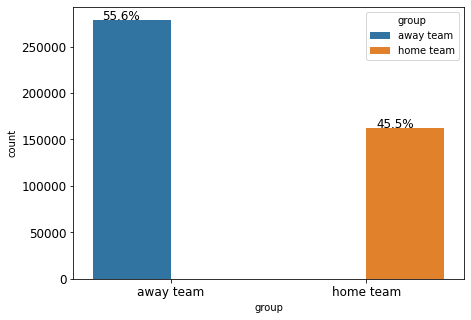

time: 931 ms


In [13]:
my_colors = 'rbg'
ax = plt.gca()
ax.bar(tracking_df2.Time, tracking_df2.group,color=my_colors,width=2)

def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
    plt.show()


plt.figure(figsize=(7,5))
ax=sns.countplot('group',hue='group',data=tracking_df)
plt.xticks(size=12)
plt.ylabel('count')
plt.yticks(size=12)
with_hue(ax,tracking_df.ball_handler_team,2,2)

## Capture team shape when Home Team in possession ##

In [110]:
All_summary_frames = sequence_summary_frames[0::10]

A1=[]

for F in All_summary_frames:

    group='home team'
    def_seg = tracking_df_x1[(tracking_df_x1['frame'] == F) & 
                             (tracking_df_x1['group'] == group) &
                            (tracking_df_x1['position_name'] != 'Ball')].reset_index(drop=True)

    
    def_seg=def_seg[['frame','jersey_number','x1','y1']]
    
    def_seg['centroid_x'] = def_seg.x1.mean()
    def_seg['centroid_y'] = def_seg.y1.mean()

    def closest_point(point, points):
        """ Find closest point from a list of points. """
        return points[cdist([point], points).argmin()]

    def match_value(df, col1, x, col2):
        """ Match value x from col1 row to value in col2. """
        return df[df[col1] == x][col2].values[0]

    
    def_seg['centroid_xy'] = [(x, y) for x,y in zip(def_seg['centroid_x'], def_seg['centroid_y'])]
    def_seg['xy'] = [(x, y) for x,y in zip(def_seg['x1'], def_seg['y1'])]

    def_seg['closest1'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['centroid_xy']]
    def_seg['player1'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest1']]

    def_seg=def_seg[def_seg['closest1']!=def_seg['xy']].reset_index(drop=True)

    def_seg['closest2'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest1']]
    def_seg['player2'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest2']]

    def_seg=def_seg[def_seg['closest2']!=def_seg['xy']].reset_index(drop=True)
    
    def_seg['closest3'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest2']]
    def_seg['player3'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest3']]

    def_seg=def_seg[def_seg['closest3']!=def_seg['xy']].reset_index(drop=True)
    
    def_seg['closest4'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest3']]
    def_seg['player4'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest4']]

    def_seg=def_seg[def_seg['closest4']!=def_seg['xy']].reset_index(drop=True)
    
    def_seg['closest5'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest4']]
    def_seg['player5'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest5']]

    def_seg=def_seg[def_seg['closest5']!=def_seg['xy']].reset_index(drop=True)
    
    def_seg['closest6'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest5']]
    def_seg['player6'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest6']]

    def_seg=def_seg[def_seg['closest6']!=def_seg['xy']].reset_index(drop=True)
    
    def_seg['closest7'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest6']]
    def_seg['player7'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest7']]

    def_seg=def_seg[def_seg['closest7']!=def_seg['xy']].reset_index(drop=True)
    
    def_seg['closest8'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest7']]
    def_seg['player8'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest8']]

    def_seg=def_seg[def_seg['closest8']!=def_seg['xy']].reset_index(drop=True)
    
    
    def_seg['closest9'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest8']]
    def_seg['player9'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest9']]

    def_seg=def_seg[def_seg['closest9']!=def_seg['xy']].reset_index(drop=True)
    
    
    def_seg['closest10'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest9']]
    def_seg['player10'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest10']]
   
    def_seg['closest11'] = [closest_point(x, list(def_seg['closest1'])) for x in def_seg['closest10']]
    def_seg['player11'] = [match_value(def_seg, 'closest1', x, 'jersey_number') for x in def_seg['closest11']]
    
    def_seg=def_seg.drop_duplicates(subset=['frame'], keep="first")

    A1.append(def_seg)
    
A2=pd.concat(A1)

## Keep only certain columns ##
A3 = A2.filter(regex='closest|frame')
A3.index=A3.frame
del A3['frame']
A3_cols=A3.columns

closest_12=[]
closest_23=[]
closest_34=[]
closest_45=[]
closest_56=[]
closest_67=[]
closest_78=[]
closest_89=[]
closest_910=[]
closest_1011=[]


for index, row in A3.iterrows():
    
    x12=row['closest2'][0] - row['closest1'][0]
    y12=row['closest2'][1] - row['closest1'][1]
    x23=row['closest3'][0] - row['closest2'][0]
    y23=row['closest3'][1] - row['closest2'][1]
    x34=row['closest4'][0] - row['closest3'][0]
    y34=row['closest4'][1] - row['closest3'][1]
    x45=row['closest5'][0] - row['closest4'][0]
    y45=row['closest5'][1] - row['closest4'][1]
    x56=row['closest6'][0] - row['closest5'][0]
    y56=row['closest6'][1] - row['closest5'][1]
    x67=row['closest7'][0] - row['closest6'][0]
    y67=row['closest7'][1] - row['closest6'][1]
    x78=row['closest8'][0] - row['closest7'][0]
    y78=row['closest8'][1] - row['closest7'][1]
    x89=row['closest9'][0] - row['closest8'][0]
    y89=row['closest9'][1] - row['closest8'][1]
    x910=row['closest10'][0] - row['closest9'][0]
    y910=row['closest10'][1] - row['closest9'][1]
    x1011=row['closest11'][0] - row['closest10'][0]
    y1011=row['closest11'][1] - row['closest10'][1]
    closest_12.append((x12,y12))
    closest_23.append((x23,y23))
    closest_34.append((x34,y34))
    closest_45.append((x45,y45))
    closest_56.append((x56,y56))
    closest_67.append((x67,y67))
    closest_78.append((x78,y78))
    closest_89.append((x89,y89))
    closest_910.append((x910,y910))
    closest_1011.append((x1011,y1011))
    
New_df=pd.DataFrame({'closest_12':closest_12,
                     'closest_23':closest_23,
                    'closest_34':closest_34,
                     'closest_45':closest_45,
                     'closest_56':closest_56,
                     'closest_67':closest_67,
                     'closest_78':closest_78,
                     'closest_89':closest_89,
                     'closest_910':closest_910,
                     'closest_1011':closest_1011},index=A3.index)

New_df[['closest_12_x','closest_12_y']] = New_df['closest_12'].apply(pd.Series)
New_df[['closest_23_x','closest_23_y']] = New_df['closest_23'].apply(pd.Series)
New_df[['closest_34_x','closest_34_y']] = New_df['closest_34'].apply(pd.Series)
New_df[['closest_45_x','closest_45_y']] = New_df['closest_45'].apply(pd.Series)
New_df[['closest_56_x','closest_56_y']] = New_df['closest_56'].apply(pd.Series)
New_df[['closest_67_x','closest_67_y']] = New_df['closest_67'].apply(pd.Series)
New_df[['closest_78_x','closest_78_y']] = New_df['closest_78'].apply(pd.Series)
New_df[['closest_89_x','closest_89_y']] = New_df['closest_89'].apply(pd.Series)
New_df[['closest_910_x','closest_910_y']] = New_df['closest_910'].apply(pd.Series)
New_df[['closest_1011_x','closest_1011_y']] = New_df['closest_1011'].apply(pd.Series)


New_df1=New_df.iloc[:,10:]
New_df1['Team']=group


time: 2min 42s


In [111]:
A1=[]

for F in All_summary_frames:

    group='away team'
    def_seg = tracking_df_x1[(tracking_df_x1['frame'] == F) & 
                             (tracking_df_x1['group'] == group) &
                            (tracking_df_x1['position_name'] != 'Ball')].reset_index(drop=True)

    
    def_seg=def_seg[['frame','jersey_number','x1','y1']]
    
    def_seg['centroid_x'] = def_seg.x1.mean()
    def_seg['centroid_y'] = def_seg.y1.mean()

    def closest_point(point, points):
        """ Find closest point from a list of points. """
        return points[cdist([point], points).argmin()]

    def match_value(df, col1, x, col2):
        """ Match value x from col1 row to value in col2. """
        return df[df[col1] == x][col2].values[0]

    
    def_seg['centroid_xy'] = [(x, y) for x,y in zip(def_seg['centroid_x'], def_seg['centroid_y'])]
    def_seg['xy'] = [(x, y) for x,y in zip(def_seg['x1'], def_seg['y1'])]

    def_seg['closest1'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['centroid_xy']]
    def_seg['player1'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest1']]

    def_seg=def_seg[def_seg['closest1']!=def_seg['xy']].reset_index(drop=True)

    def_seg['closest2'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest1']]
    def_seg['player2'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest2']]

    def_seg=def_seg[def_seg['closest2']!=def_seg['xy']].reset_index(drop=True)
    
    def_seg['closest3'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest2']]
    def_seg['player3'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest3']]

    def_seg=def_seg[def_seg['closest3']!=def_seg['xy']].reset_index(drop=True)
    
    def_seg['closest4'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest3']]
    def_seg['player4'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest4']]

    def_seg=def_seg[def_seg['closest4']!=def_seg['xy']].reset_index(drop=True)
    
    def_seg['closest5'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest4']]
    def_seg['player5'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest5']]

    def_seg=def_seg[def_seg['closest5']!=def_seg['xy']].reset_index(drop=True)
    
    def_seg['closest6'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest5']]
    def_seg['player6'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest6']]

    def_seg=def_seg[def_seg['closest6']!=def_seg['xy']].reset_index(drop=True)
    
    def_seg['closest7'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest6']]
    def_seg['player7'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest7']]

    def_seg=def_seg[def_seg['closest7']!=def_seg['xy']].reset_index(drop=True)
    
    def_seg['closest8'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest7']]
    def_seg['player8'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest8']]

    def_seg=def_seg[def_seg['closest8']!=def_seg['xy']].reset_index(drop=True)
    
    
    def_seg['closest9'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest8']]
    def_seg['player9'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest9']]

    def_seg=def_seg[def_seg['closest9']!=def_seg['xy']].reset_index(drop=True)
    
    
    def_seg['closest10'] = [closest_point(x, list(def_seg['xy'])) for x in def_seg['closest9']]
    def_seg['player10'] = [match_value(def_seg, 'xy', x, 'jersey_number') for x in def_seg['closest10']]
   
    def_seg['closest11'] = [closest_point(x, list(def_seg['closest1'])) for x in def_seg['closest10']]
    def_seg['player11'] = [match_value(def_seg, 'closest1', x, 'jersey_number') for x in def_seg['closest11']]
    
    def_seg=def_seg.drop_duplicates(subset=['frame'], keep="first")

    A1.append(def_seg)
    
A2=pd.concat(A1)

## Keep only certain columns ##
A3 = A2.filter(regex='closest|frame')
A3.index=A3.frame
del A3['frame']
A3_cols=A3.columns

closest_12=[]
closest_23=[]
closest_34=[]
closest_45=[]
closest_56=[]
closest_67=[]
closest_78=[]
closest_89=[]
closest_910=[]
closest_1011=[]


for index, row in A3.iterrows():
    
    x12=row['closest2'][0] - row['closest1'][0]
    y12=row['closest2'][1] - row['closest1'][1]
    x23=row['closest3'][0] - row['closest2'][0]
    y23=row['closest3'][1] - row['closest2'][1]
    x34=row['closest4'][0] - row['closest3'][0]
    y34=row['closest4'][1] - row['closest3'][1]
    x45=row['closest5'][0] - row['closest4'][0]
    y45=row['closest5'][1] - row['closest4'][1]
    x56=row['closest6'][0] - row['closest5'][0]
    y56=row['closest6'][1] - row['closest5'][1]
    x67=row['closest7'][0] - row['closest6'][0]
    y67=row['closest7'][1] - row['closest6'][1]
    x78=row['closest8'][0] - row['closest7'][0]
    y78=row['closest8'][1] - row['closest7'][1]
    x89=row['closest9'][0] - row['closest8'][0]
    y89=row['closest9'][1] - row['closest8'][1]
    x910=row['closest10'][0] - row['closest9'][0]
    y910=row['closest10'][1] - row['closest9'][1]
    x1011=row['closest11'][0] - row['closest10'][0]
    y1011=row['closest11'][1] - row['closest10'][1]
    closest_12.append((x12,y12))
    closest_23.append((x23,y23))
    closest_34.append((x34,y34))
    closest_45.append((x45,y45))
    closest_56.append((x56,y56))
    closest_67.append((x67,y67))
    closest_78.append((x78,y78))
    closest_89.append((x89,y89))
    closest_910.append((x910,y910))
    closest_1011.append((x1011,y1011))
    
New_df=pd.DataFrame({'closest_12':closest_12,
                     'closest_23':closest_23,
                    'closest_34':closest_34,
                     'closest_45':closest_45,
                     'closest_56':closest_56,
                     'closest_67':closest_67,
                     'closest_78':closest_78,
                     'closest_89':closest_89,
                     'closest_910':closest_910,
                     'closest_1011':closest_1011},index=A3.index)

New_df[['closest_12_x','closest_12_y']] = New_df['closest_12'].apply(pd.Series)
New_df[['closest_23_x','closest_23_y']] = New_df['closest_23'].apply(pd.Series)
New_df[['closest_34_x','closest_34_y']] = New_df['closest_34'].apply(pd.Series)
New_df[['closest_45_x','closest_45_y']] = New_df['closest_45'].apply(pd.Series)
New_df[['closest_56_x','closest_56_y']] = New_df['closest_56'].apply(pd.Series)
New_df[['closest_67_x','closest_67_y']] = New_df['closest_67'].apply(pd.Series)
New_df[['closest_78_x','closest_78_y']] = New_df['closest_78'].apply(pd.Series)
New_df[['closest_89_x','closest_89_y']] = New_df['closest_89'].apply(pd.Series)
New_df[['closest_910_x','closest_910_y']] = New_df['closest_910'].apply(pd.Series)
New_df[['closest_1011_x','closest_1011_y']] = New_df['closest_1011'].apply(pd.Series)


New_df2=New_df.iloc[:,10:]
New_df2['Team']=group
New_df_final=New_df1.append(New_df2)

time: 3min 56s


In [138]:
New_df_final=New_df1.append(New_df2)
del_cols=['Team','frame']
cols_list=[i for i in list(New_df_final.columns) if i not in del_cols]
New_df_final=pd.merge(New_df_final,df,on='frame',how='left')
New_df_final2=New_df_final.groupby(['sequence_id', 'Team'])[cols_list].mean().reset_index()
New_df_final3=New_df_final2.iloc[:,2:]

time: 16 ms


In [149]:
scaler = StandardScaler()

X = scaler.fit_transform(New_df_final3)

hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage ='ward')
# Lets try to fit the hierarchical clustering algorithm  to dataset #X while creating the clusters vector that tells for each customer #which cluster the customer belongs to.
y_hc=hc.fit_predict(X)

New_df_final2['Clusters']=y_hc

New_df_final2.frame=New_df_final.index

New_df_final2.to_csv(r'C:\Users\Home\Documents\Clusters.csv')

time: 14 ms


In [154]:
df

sequence_id  frame
0                3    697
1                3    698
2                3    699
3                3    700
4                3    701
...            ...    ...
19895          150  64644
19896          150  64645
19897          150  64646
19898          150  64647
19899          150  64648

[19900 rows x 2 columns]

time: 11 ms


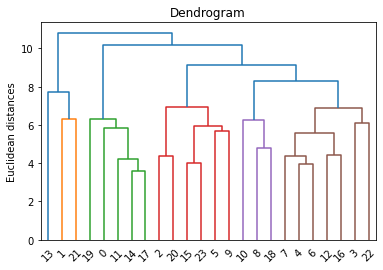

time: 276 ms


In [150]:
scaler = StandardScaler()

X = scaler.fit_transform(New_df_final3)

dendrogram = sch.dendrogram(sch.linkage(X, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('')
plt.ylabel('Euclidean distances')
plt.show()

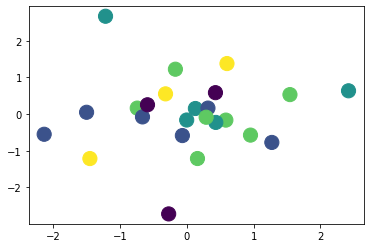

time: 129 ms


In [151]:
labels = hc.labels_

plt.scatter(X[:,0], X[:,1], c=labels,s=200,label="n_cluster-"+str(i))
plt.show()

In [152]:
labels

array([2, 0, 1, 3, 3, 1, 3, 3, 4, 1, 4, 2, 3, 0, 2, 1, 3, 2, 4, 2, 1, 0,
       3, 1], dtype=int64)

time: 2.99 ms


In [144]:
New_df_final2

sequence_id       Team  closest_12_x  closest_12_y  closest_23_x  \
0             3  home team     -0.641509      2.433962      1.773585   
1            11  home team      1.266667      0.333333     -0.400000   
2            21  home team      2.245614     -1.035088     -0.333333   
3            28  away team      0.571429      0.978022      0.560440   
4            34  away team      1.447368     -0.421053      1.000000   
5            42  away team     -1.706897     -0.810345      0.741379   
6            50  away team      1.875000     -0.833333      1.208333   
7            52  away team      0.954545     -1.477273      0.500000   
8            56  away team      1.466667      1.133333      1.600000   
9            60  away team     -0.970588     -0.205882     -0.235294   
10           62  away team     -0.913043     -1.478261      2.434783   
11           64  away team      0.918367     -0.102041      0.612245   
12           67  home team     -0.090909     -0.090909      2.340909   
13           96  away team      0.454545     -3.000000     -1.000000   
14          110  away team      1.272727     -0.484848      2.272727   
15          118  away team      1.136364     -0.090909      2.090909   
16          124  away team      1.105263     -0.342105      2.578947   
17          128  away team      0.767442     -0.418605      1.023256   
18          132  away team      0.400000      0.300000      2.825000   
19          136  away team      3.576923      0.384615      0.038462   
20          137  home team      0.000000     -0.333333     -1.222222   
21          142  away team      0.086957      0.000000     -1.652174   
22          144  away team      2.560000      0.280000     -0.120000   
23          150  away team      0.692308     -0.846154      3.307692   

    closest_23_y  closest_34_x  closest_34_y  closest_45_x  closest_45_y  ...  \
0       1.433962      1.773585      1.716981      2.641509     -1.698113  ...   
1      -0.466667     -1.666667      1.266667     -3.400000     -1.000000  ...   
2      -0.754386      2.508772     -1.964912     -0.438596      1.807018  ...   
3      -0.593407      1.175824      0.978022      1.175824      0.098901  ...   
4       0.342105      3.131579      1.578947      0.868421      0.052632  ...   
5       0.620690      1.431034     -1.224138      0.413793     -0.051724  ...   
6       0.000000     -0.375000     -0.208333     -0.208333      1.208333  ...   
7      -0.431818      1.022727      0.227273      1.795455     -0.659091  ...   
8      -3.533333      1.666667     -0.133333      0.666667      0.133333  ...   
9      -0.058824      0.823529      1.705882      0.000000      1.676471  ...   
10     -2.391304      2.391304     -2.347826      1.391304      0.956522  ...   
11      1.102041      0.755102      0.408163     -0.428571     -1.857143  ...   
12     -0.636364      1.500000      0.454545      3.136364      0.704545  ...   
13     -2.454545     -1.000000     -0.818182     -2.363636      0.181818  ...   
14     -1.272727      1.151515      0.636364      0.060606     -0.424242  ...   
15     -1.318182      1.000000      0.454545      2.000000      1.818182  ...   
16     -1.026316      1.552632      0.789474      1.500000      1.684211  ...   
17     -0.604651      2.023256     -0.023256      0.023256     -0.465116  ...   
18      0.100000      1.150000      0.025000      0.725000     -1.500000  ...   
19      0.769231      1.384615     -0.538462      2.653846     -0.961538  ...   
20     -1.666667      2.666667     -2.000000      0.888889      0.555556  ...   
21      0.391304     -2.304348     -1.652174     -0.913043      0.304348  ...   
22      0.840000     -0.480000     -0.120000      1.840000      0.840000  ...   
23      0.153846      2.615385     -1.384615      1.846154      1.846154  ...   

    closest_67_y  closest_78_x  closest_78_y  closest_89_x  closest_89_y  \
0      -1.037736      0.471698     -1.377358     -0.924528     -1.716981   
1       1.266667      1.4

time: 32.9 ms


## Capture team shape when Home Team out of possession ##

## Fuzzy Merge- Match ##

In [19]:
check=tracking_df[tracking_df['ball_handler']!='Ball'][['x','y','z','Time','frame','ball_handler_number']].reset_index(drop=True)
check['Time1']=check.Time.astype(str)
check['ball_handler_number1'] = pd.Series(["{0:0=2d}".format(val) for val in check['ball_handler_number']], index = check.index)
check.Time1=check.Time1.str.replace(".","")
check['Match']=check['Time1']+check['ball_handler_number1']

check=check.sort_values(['Time','Match'], ascending=[True,True]).drop_duplicates(subset='Match', keep="last")


check1=Event_data_df[['event_start_x','event_start_y','Time','number','Player_Name','eventName','subEventName']]
check1['Time1']=check1.Time.astype(str)
check1['number1'] = pd.Series(["{0:0=2d}".format(val) for val in check1['number']], index = check1.index)
check1.Time1=check1.Time1.str.replace(".","")
check1['Match']=check1['Time1']+check1['number1']
check1=check1.sort_values(['Time','Match'], ascending=[True,True])
#check1.head(50)

def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=2):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()
    
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1

fuzzy_merge1=fuzzy_merge(check,check1, 'Match', 'Match', threshold=100)

65555
380
time: 172 ms


In [384]:
New_df=A3.copy()
New_df[['closest_1x','closest_1y']] = New_df['closest1'].apply(pd.Series)
New_df[['closest_2x','closest_2y']] = New_df['closest2'].apply(pd.Series)
New_df[['closest_3x','closest_3y']] = New_df['closest3'].apply(pd.Series)
New_df[['closest_4x','closest_4y']] = New_df['closest4'].apply(pd.Series)
New_df[['closest_5x','closest_5y']] = New_df['closest5'].apply(pd.Series)
New_df[['closest_6x','closest_6y']] = New_df['closest6'].apply(pd.Series)
New_df[['closest_7x','closest_7y']] = New_df['closest7'].apply(pd.Series)
New_df[['closest_8x','closest_8y']] = New_df['closest8'].apply(pd.Series)
New_df[['closest_9x','closest_9y']] = New_df['closest9'].apply(pd.Series)
New_df[['closest_10x','closest_10y']] = New_df['closest10'].apply(pd.Series)

New_df1=New_df.iloc[:,11:]
New_df1

closest_1x  closest_1y  closest_2x  closest_2y  closest_3x  closest_3y  \
frame                                                                           
404            45          30          42          22          45          16   
416            46          29          42          21          46          16   
428            46          29          43          20          47          17   
440            46          28          43          19          47          17   
452            46          28          44          19          47          18   
...           ...         ...         ...         ...         ...         ...   
65248          34          16          23          16          26          27   
65260          34          14          37           4          23           2   
65272          34          12          37           4          24           3   
65284          34          11          36           4          26           3   
65296          35          11          36           4          27           4   

       closest_4x  closest_4y  closest_5x  closest_5y  closest_6x  closest_6y  \
frame                                                                           
404            35          16          34          36          36          40   
416            35          16          34          36          36          39   
428            35          16          34          35          38          38   
440            35          16          34          34          39          37   
452            35          16          35          33          40          37   
...           ...         ...         ...         ...         ...         ...   
65248          31          27          45          25          53          32   
65260          23          15          26          26          31          25   
65272          24          15          26          24          30          23   
65284          24          14          27          22          30          22   
65296          24          13          26          21          30          20   

       closest_7x  closest_7y  closest_8x  closest_8y  closest_9x  closest_9y  \
frame                                                                           
404            54          44          63          49          58          56   
416            53          44          63          49          59          56   
428            53          44          64          48          59          55   
440            52          44          64          47          59          55   
452            51          45          60          54          64          46   
...           ...         ...         ...         ...         ...         ...   
65248          39          40          55          10          38           4   
65260          45          24          53          31          38          38   
65272          44          23          52          30          37          37   
65284          44          21          52          29          36          35   
65296          43          21          51          28          35          33   

       closest_10x  closest_10y  
frame                            
404             63           20  
416             63           21  
428             62           22  
440             62           23  
452             62           24  
...            ...          ...  
65248           23            2  
65260           54            9  
65272           53            8  
65284           52            7  
65296           51            7  

[1866 rows x 20 columns]

time: 3.69 s


In [85]:
team1_centroids1=team1_centroids[(team1_centroids['centroid_x']>=45) & (team1_centroids['centroid_x']<=55)].reset_index(drop=True)

Mid_Block_Frames= list(set(team1_centroids1['frame']))

A3=tracking_df[tracking_df['frame'].isin(Mid_Block_Frames)].reset_index(drop=True)
A3=pd.merge(A3,team1_centroids1,on='frame',how='left')

Mid_Block_Frames=Mid_Block_Frames[3:10]

time: 623 ms


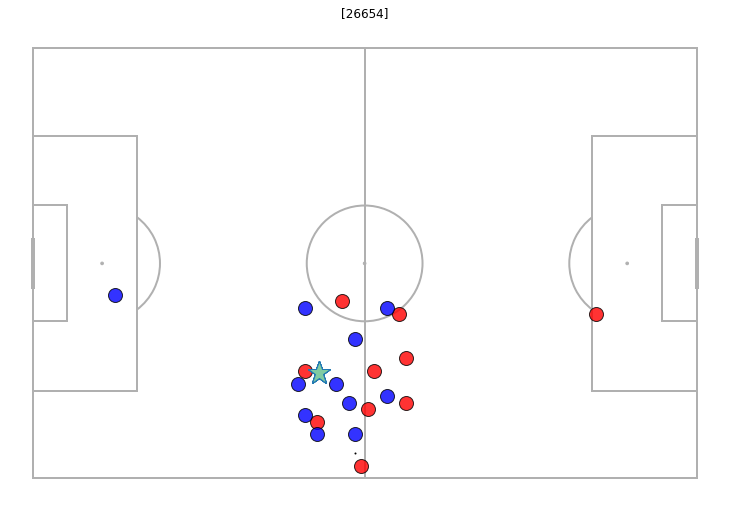

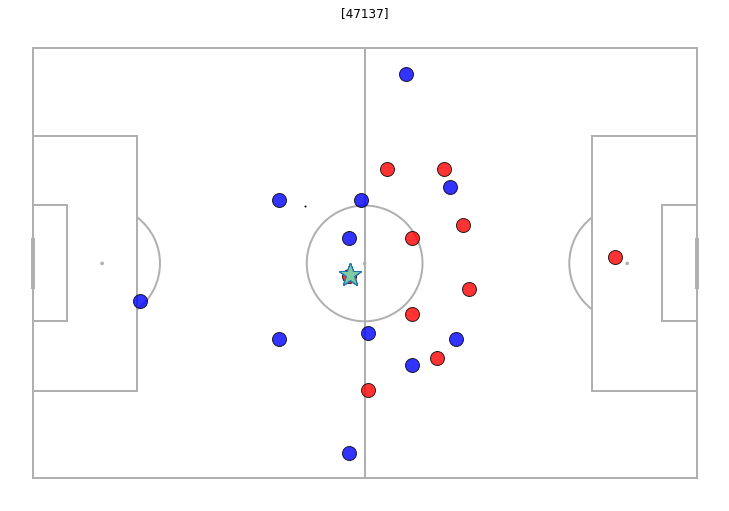

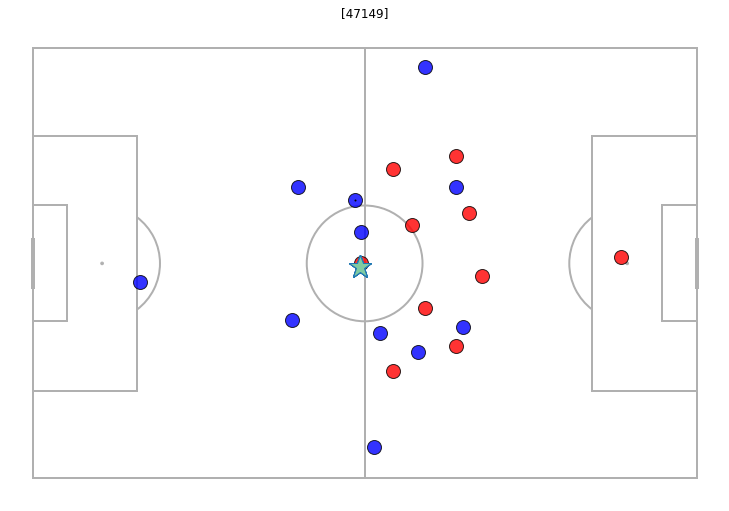

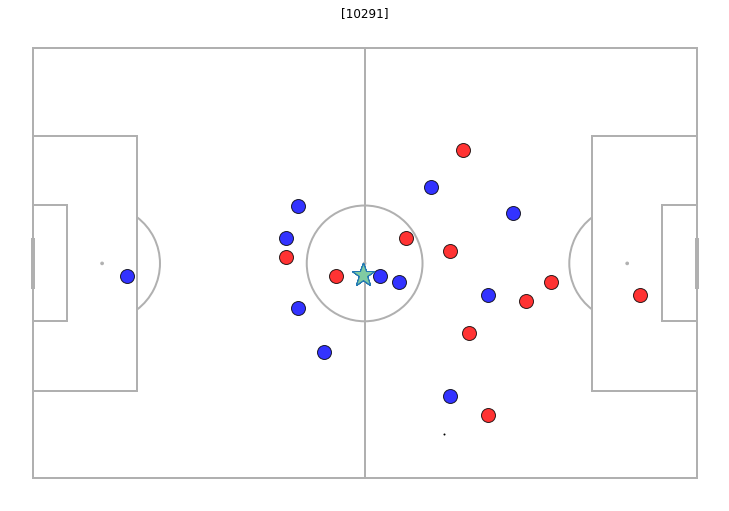

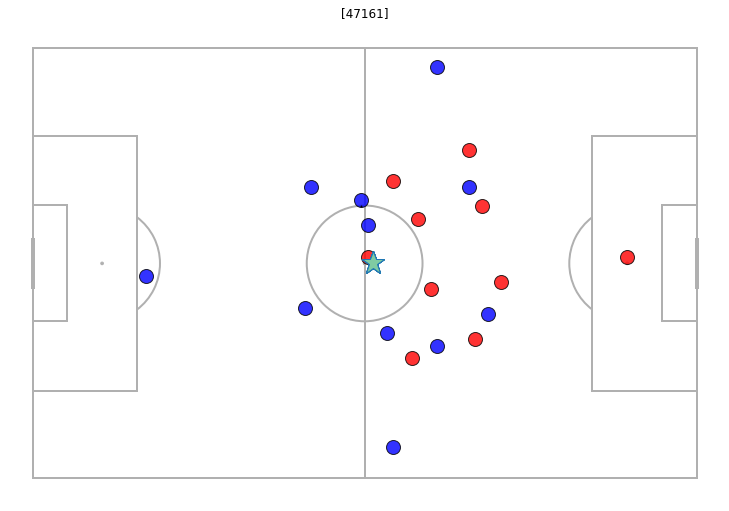

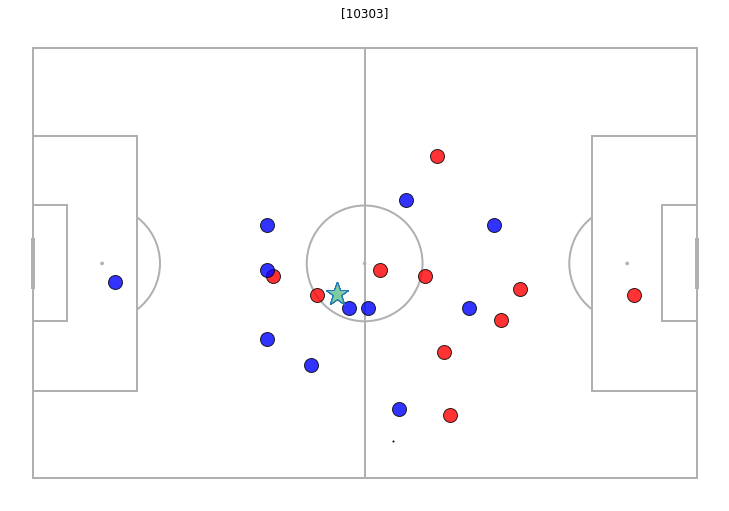

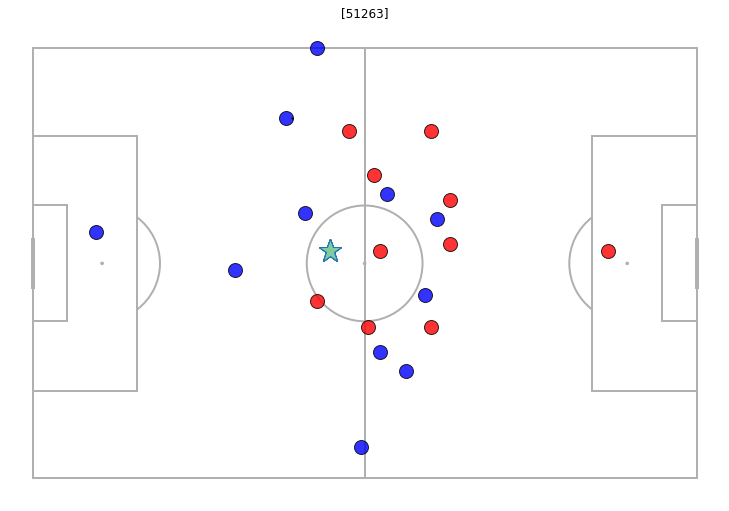

time: 1.86 s


In [86]:
from mplsoccer.pitch import Pitch
#%matplotlib widget
import matplotlib.patches as patches
import matplotlib.pyplot as plt


for k in Mid_Block_Frames:

    frame___ = A3[(A3['frame'] == k)].reset_index(drop=True)

    b_fra = frame___[frame___['team_name'] == 'Ball'].reset_index(drop=True)

    t_fra = frame___[frame___['team_name'] == 'Leicester City'].reset_index(drop=True)
    o_fra = frame___[(frame___['team_name'] != 'Leicester City') & (frame___['team_name'] != 'Ball')].reset_index(drop=True)
    centroid_fra = frame___[(frame___['team_name'] == 'Leicester City')].reset_index(drop=True)

    o_fra=o_fra.sort_values(by='y1')

    # print(o_fra)
    pitch = Pitch(pitch_type='statsperform',orientation='horizontal',view='full',layout=(1,1),figsize=(10.8, 7.2),
        pitch_width=68,pitch_length=105,stripe=False,goal_type='line',axis=False,label=True)
    fig, ax = pitch.draw()


    ax.plot(t_fra.x1, t_fra.y1, 'ko', ms=14,markerfacecolor='blue', zorder=2,alpha=0.8) #red/maroon
    ax.plot(o_fra.x1, o_fra.y1, 'ko', ms=14,markerfacecolor='red', zorder=1,alpha=0.8) #red/maroon
    ax.plot(b_fra.ball_x1, b_fra.ball_y1, 'ko', ms=1,markerfacecolor='yellow', zorder=4) #red/maroon
    ax.plot(centroid_fra.centroid_x, centroid_fra.centroid_y, '*', ms=24,markerfacecolor='#80CBA2', zorder=8)

    plt.title(str(frame___.frame.unique()))

    plt.savefig(r'C:\Users\Home\Documents\Player Formation/'+'image'+str(k)+'.png')

In [116]:
## Subset clusters to view formation ## - Cluster 0
Cluster_0=New_df_final[New_df_final['Clusters']==0][['frame','Team','Clusters','sequence_id']]

Cluster_0

frame       Team  Clusters  sequence_id
8      777  home team         0            3
9      787  home team         0            3
13     827  home team         0            3
40    1097  home team         0            3
53    3588  home team         0           11
..     ...        ...       ...          ...
779  61664  away team         0          142
780  61674  away team         0          142
787  61744  away team         0          142
790  61846  away team         0          144
827  64109  away team         0          150

[103 rows x 4 columns]

time: 17.5 ms


Text(0.5, 1.0, '60824')

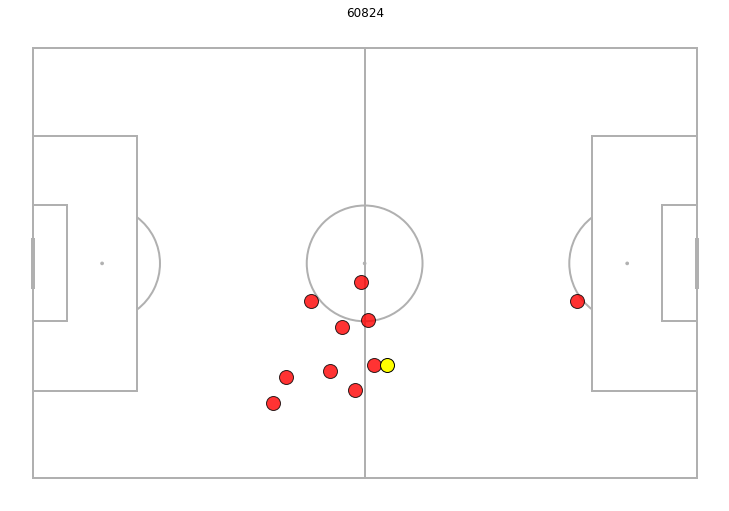

time: 261 ms


In [170]:
from mplsoccer.pitch import Pitch
#%matplotlib widget
import matplotlib.patches as patches
import matplotlib.pyplot as plt

frame___ = tracking_df[(tracking_df['frame'] == 60824)].reset_index(drop=True)

b_fra = frame___[frame___['team_name'] == 'Ball'].reset_index(drop=True)

t_fra = frame___[frame___['team_name'] == 'Leicester City'].reset_index(drop=True)
o_fra = frame___[(frame___['team_name'] != 'Leicester City') & (frame___['team_name'] != 'Ball')].reset_index(drop=True)
#centroid_fra = frame___[(frame___['team_name'] == 'Leicester City')].reset_index(drop=True)

o_fra=o_fra.sort_values(by='y1')

# print(o_fra)
pitch = Pitch(pitch_type='statsperform',orientation='horizontal',view='full',layout=(1,1),figsize=(10.8, 7.2),
    pitch_width=68,pitch_length=105,stripe=False,goal_type='line',axis=False,label=True)
fig, ax = pitch.draw()


#ax.plot(t_fra.x1, t_fra.y1, 'ko', ms=14,markerfacecolor='blue', zorder=2,alpha=0.8) #red/maroon
ax.plot(o_fra.x1, o_fra.y1, 'ko', ms=14,markerfacecolor='red', zorder=1,alpha=0.8) #red/maroon
ax.plot(b_fra.x1, b_fra.y1, 'ko', ms=14,markerfacecolor='yellow', zorder=4) #red/maroon
#ax.plot(centroid_fra.centroid_x, centroid_fra.centroid_y, '*', ms=24,markerfacecolor='#80CBA2', zorder=8)

plt.title(str(frame___.frame[0]))

Text(0.5, 1.0, '59536')

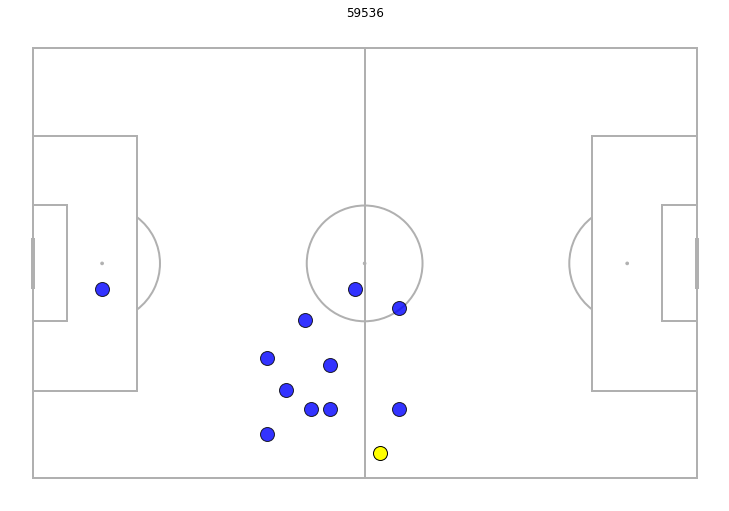

time: 296 ms


In [180]:
from mplsoccer.pitch import Pitch
#%matplotlib widget
import matplotlib.patches as patches
import matplotlib.pyplot as plt

frame___ = tracking_df[(tracking_df['frame'] == 59536)].reset_index(drop=True)

b_fra = frame___[frame___['team_name'] == 'Ball'].reset_index(drop=True)

t_fra = frame___[frame___['team_name'] == 'Leicester City'].reset_index(drop=True)
o_fra = frame___[(frame___['team_name'] != 'Leicester City') & (frame___['team_name'] != 'Ball')].reset_index(drop=True)
#centroid_fra = frame___[(frame___['team_name'] == 'Leicester City')].reset_index(drop=True)

o_fra=o_fra.sort_values(by='y1')

# print(o_fra)
pitch = Pitch(pitch_type='statsperform',orientation='horizontal',view='full',layout=(1,1),figsize=(10.8, 7.2),
    pitch_width=68,pitch_length=105,stripe=False,goal_type='line',axis=False,label=True)
fig, ax = pitch.draw()


ax.plot(t_fra.x1, t_fra.y1, 'ko', ms=14,markerfacecolor='blue', zorder=2,alpha=0.8) #red/maroon
#ax.plot(o_fra.x1, o_fra.y1, 'ko', ms=14,markerfacecolor='red', zorder=1,alpha=0.8) #red/maroon
ax.plot(b_fra.x1, b_fra.y1, 'ko', ms=14,markerfacecolor='yellow', zorder=4) #red/maroon
#ax.plot(centroid_fra.centroid_x, centroid_fra.centroid_y, '*', ms=24,markerfacecolor='#80CBA2', zorder=8)

plt.title(str(frame___.frame[0]))

In [50]:
tracking_df.columns

Index(['trackable_object', 'is_visible', 'x', 'y', 'z', 'frame', 'period',
       'group', 'trackable_object_y', 'Time', 'Full_Name', 'Age',
       'jersey_number', 'yellow_card', 'red_card', 'injured', 'goal',
       'own_goal', 'team_player_id', 'team_id', 'player_id', 'position_id',
       'position_name', 'position_acronym', 'team_name', 'x1', 'y1', 'ball_x1',
       'ball_y1', 'ball_z', 'distance_to_ball', 'distance_to_goal1',
       'distance_to_goal2', 'rank', 'ball_handler', 'ball_handler_number',
       'ball_handler_team', 'team_possession'],
      dtype='object')

time: 3.99 ms


In [ ]:
clusters_centroids=team1_centroids[['centroid_x','centroid_y']]

In [51]:
df1=pd.merge(df1,team1_centroids,on='frame',how='left')
df1

trackable_object is_visible       x       y    z  frame  period  \
0                     55       True  58.338  44.268  2.2    500     1.0   
1                     55       True  58.338  44.268  2.2    500     1.0   
2                     55       True  58.338  44.268  2.2    500     1.0   
3                     55       True  58.338  44.268  2.2    500     1.0   
4                     55       True  58.338  44.268  2.2    500     1.0   
...                  ...        ...     ...     ...  ...    ...     ...   
106324              5750      False  17.594  45.696  0.0    700     1.0   
106325              5750      False  17.594  45.696  0.0    700     1.0   
106326              5750      False  17.594  45.696  0.0    700     1.0   
106327              5750      False  17.594  45.696  0.0    700     1.0   
106328              5750      False  17.594  45.696  0.0    700     1.0   

            group  trackable_object_y  Time  ... distance_to_ball  \
0            None                   0   0.1  ...             0.00   
1            None                   0   0.1  ...             0.00   
2            None                   0   0.1  ...             0.00   
3            None                   0   0.1  ...             0.00   
4            None                   0   0.1  ...             0.00   
...           ...                 ...   ...  ...              ...   
106324  home team               18862   0.3  ...            58.52   
106325  home team               18862   0.3  ...            58.52   
106326  home team               18862   0.3  ...            58.52   
106327  home team               18862   0.3  ...            58.52   
106328  home team               18862   0.3  ...            58.52   

        distance_to_goal1  distance_to_goal2  rank  ball_handler  \
0              126.346896          44.299188   1.0          Ball   
1              126.346896          44.299188   1.0          Ball   
2              126.346896          44.299188   1.0          Ball   
3              126.346896          44.299188   1.0          Ball   
4              126.346896          44.299188   1.0          Ball   
...                   ...                ...   ...           ...   
106324          90.049727          62.340944  22.0          Ball   
106325          90.049727          62.340944  22.0          Ball   
106326          90.049727          62.340944  22.0          Ball   
106327          90.049727          62.340944  22.0          Ball   
106328          90.049727          62.340944  22.0          Ball   

       ball_handler_number  ball_handler_team  Team_in_Possession  centroid_x  \
0                        0        Southampton                   1        53.5   
1                        0        Southampton                   1        53.5   
2                        0        Southampton                   1        53.5   
3                        0        Southampton                   1        53.5   
4                        0        Southampton                   1        53.5   
...                    ...                ...                 ...         ...   
106324                   0        Southampton                   1        73.5   
106325                   0        Southampton                   1        73.5   
106326                   0        Southampton                   1        73.5   
106327                   0        Southampton                   1        73.5   
106328                   0        Southampton                   1        73.5   

        centroid_y  
0        26.583333  
1        26.583333  
2        26.583333  
3        26.583333  
4        26.583333  
...            ...  
106324   24.083333  
106325   24.083333  
106326   24.083333  
106327   24.083333  
106328   24.083333  

[106329 rows x 40 columns]

time: 855 ms


In [146]:
def_seg.to_csv(r'C:\Users\Home\Documents\def_seg.csv')

time: 30.9 ms


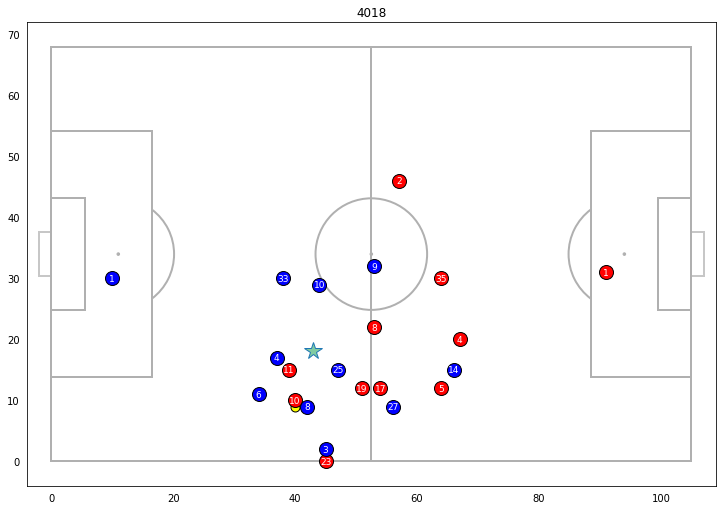

time: 1.39 s


In [178]:
#B3=tracking_df[A1['sequence']=='4-1059984']
B3=tracking_df.copy()
start=4018
end=4019

flag_0 = flag_1 = True
t0_x = t0_y = t1_x = t1_y = pd.Series(dtype=float)

def animate_shot(starting_frame, ending_frame,Eve_team):
    ##### Animate the Section to Understand 
    from matplotlib import animation
    from mplsoccer.pitch import Pitch
    #%matplotlib widget
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt

    # Set up formatting for the movie files
    import matplotlib.animation as animation
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=25, metadata=dict(artist='Me'), bitrate=1800)

    global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1
    
    frames_to_animate = list(range(starting_frame, ending_frame))

    pitch = Pitch(pitch_type='statsperform',orientation='horizontal',view='full',layout=(1,1), figsize=(10.8, 7.2),
                  pitch_width=105,pitch_length=68,stripe=False,goal_type='box', axis=True, label=True)
    fig, ax = pitch.draw()
    

    ball, = ax.plot([], [], 'ko', ms=9,markerfacecolor='yellow')
    team_0, = ax.plot([], [], 'ko', ms=14,markerfacecolor='red',alpha=1)
    team_1, = ax.plot([], [], 'ko', ms=14,markerfacecolor='blue',alpha=1)
    def_centroid, = ax.plot([], [], '*', ms=18,markerfacecolor='#80CBA2', zorder=8) #purple
    
    # initialization function: plot the background of each frame
    def init():
        ball.set_data([], [])
        team_0.set_data([], [])
        team_1.set_data([], [])
        def_centroid.set_data([], [])
        return ball, team_0, team_1,def_centroid
    
    annotations = []
    # arrows = []
    
    # animation function of dataframes' list

    
    def animate(i):
        ax.set_title(str(frames_to_animate[i]))
        
        
        global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1

        frame_ = B3[B3['frame'] == frames_to_animate[i]]
                
        #Direction=frame_['Direction'].unique()
        ball_ = frame_[frame_['team_name'] == 'Ball'].reset_index()
        
        team0_ = frame_[frame_['team_name'] == 'Southampton'].reset_index()
        number0_ = frame_[frame_['team_name'] == 'Southampton'].reset_index()[['jersey_number']]
                
        team1_ = frame_[frame_['team_name'] == 'Leicester City'].reset_index()
        number1_ = frame_[frame_['team_name'] == 'Leicester City'].reset_index()[['jersey_number']]

        
        number0_.njersey_numberumber = number0_.jersey_number.apply(lambda x: int(x))
        number1_.jersey_number = number1_.jersey_number.apply(lambda x: int(x))


        # set the ball data with the x and y positions for the ith frame
        ball.set_data(ball_.ball_x1, ball_.ball_y1)
        
        # set the player data using the frame id
        team_0.set_data(team0_.x1,team0_.y1)
        team_1.set_data(team1_.x1,team1_.y1)
        def_centroid.set_data(team1_.x1.mean(),team1_.y1.mean())

        for i, a in enumerate(annotations):
            a.remove()
        annotations[:] = []
             # update for team 0
        for k in range(len(team0_)):
            try:
                annot1 = pitch.annotate(number0_.jersey_number[k], (team0_.x1[k], team0_.y1[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot1)

            except Exception as ex:
                pass
            t0_x = team0_.x1
            t0_y = team0_.y1

        # update for team 1
        for k in range(len(team1_)):
            try:
                annot2 = pitch.annotate(number1_.jersey_number[k], (team1_.x1[k], team1_.y1[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot2)

            except Exception as ex:
                pass
            t1_x = team1_.x1
            t1_y = team1_.y1


        ax.margins(x=0, y=-0.25) 
        
        return ball, team_0, team_1,def_centroid
    
    # call the animator, animate every 300 msx`
    # note that its hard to get the ffmpeg requirements right. I installed from conda-forge: see the conda.yml file
    anim = animation.FuncAnimation(fig, animate, frames=len(frames_to_animate), init_func=init, interval=25, blit=False)
    return(anim)

#anim.save(r"C:\Users\Home\Documents\mwe.mov")
anim = animate_shot(start,end,1).to_html5_video()


HTML(anim)


In [179]:
mask = (B3['frame'] >= 4019) & (B3['frame'] <= 4019)
df1 = B3.loc[mask]

df1.to_csv(r'C:\Users\Home\Documents\C.csv')

time: 17 ms


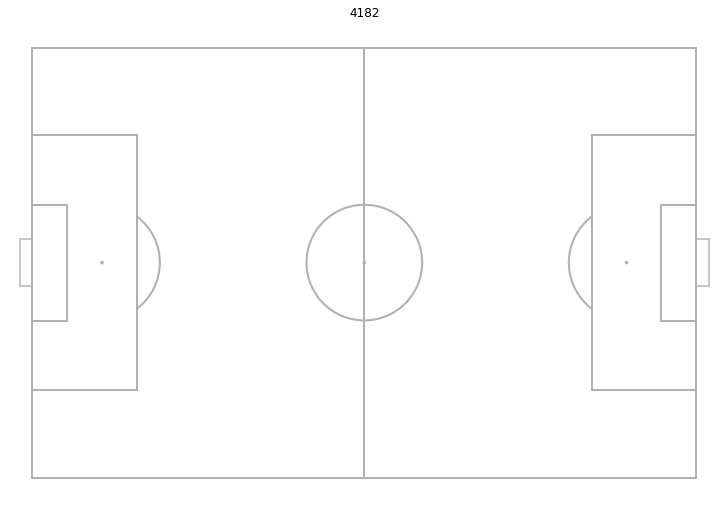

time: 1min 15s


In [171]:
#B3=tracking_df[A1['sequence']=='4-1059984']
B3=tracking_df.copy()
start=3583
end=4183

flag_0 = flag_1 = True
t0_x = t0_y = t1_x = t1_y = pd.Series(dtype=float)

def animate_shot(starting_frame, ending_frame,Eve_team):
    ##### Animate the Section to Understand 
    from matplotlib import animation
    from mplsoccer.pitch import Pitch
    #%matplotlib widget
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt

    # Set up formatting for the movie files
    import matplotlib.animation as animation
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=25, metadata=dict(artist='Me'), bitrate=1800)

    global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1
    
    frames_to_animate = list(range(starting_frame, ending_frame))

    pitch = Pitch(pitch_type='statsperform',orientation='horizontal',view='full',layout=(1,1), figsize=(10.8, 7.2),
                  pitch_width=105,pitch_length=68,stripe=False,goal_type='box', axis=False, label=False)
    fig, ax = pitch.draw()
    

    ball, = ax.plot([], [], 'ko', ms=9,markerfacecolor='yellow')
    team_0, = ax.plot([], [], 'ko', ms=14,markerfacecolor='red',alpha=1)
    team_1, = ax.plot([], [], 'ko', ms=14,markerfacecolor='blue',alpha=1)
    #def_centroid, = ax.plot([], [], '*', ms=18,markerfacecolor='#80CBA2', zorder=8) #purple


    
    # initialization function: plot the background of each frame
    def init():
        ball.set_data([], [])
        team_0.set_data([], [])
        team_1.set_data([], [])
        #def_centroid.set_data([], [])
        return ball, team_0, team_1#,def_centroid
    
    annotations = []
    # arrows = []
    
    # animation function of dataframes' list

    
    def animate(i):
        ax.set_title(str(frames_to_animate[i]))
        
        
        global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1

        frame_ = B3[B3['frame'] == frames_to_animate[i]]
                
        #Direction=frame_['Direction'].unique()
        ball_ = frame_[frame_['team_name'] == 'Ball'].reset_index()
        
        team0_ = frame_[frame_['team_name'] == 'Southampton'].reset_index()
        number0_ = frame_[frame_['team_name'] == 'Southampton'].reset_index()[['jersey_number']]
                
        team1_ = frame_[frame_['team_name'] == 'Leicester City'].reset_index()
        number1_ = frame_[frame_['team_name'] == 'Leicester City'].reset_index()[['jersey_number']]

        
        number0_.njersey_numberumber = number0_.jersey_number.apply(lambda x: int(x))
        number1_.jersey_number = number1_.jersey_number.apply(lambda x: int(x))


        # set the ball data with the x and y positions for the ith frame
        ball.set_data(ball_.ball_x1, ball_.ball_y1)
        
        # set the player data using the frame id
        team_0.set_data(team0_.x1,team0_.y1)
        team_1.set_data(team1_.x1,team1_.y1)
        #def_centroid.set_data(team0_.x1.mean(),team0_.y1.mean())

        for i, a in enumerate(annotations):
            a.remove()
        annotations[:] = []
             # update for team 0
        for k in range(len(team0_)):
            try:
                annot1 = pitch.annotate(number0_.jersey_number[k], (team0_.x1[k], team0_.y1[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot1)

            except Exception as ex:
                pass
            t0_x = team0_.x1
            t0_y = team0_.y1

        # update for team 1
        for k in range(len(team1_)):
            try:
                annot2 = pitch.annotate(number1_.jersey_number[k], (team1_.x1[k], team1_.y1[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot2)

            except Exception as ex:
                pass
            t1_x = team1_.x1
            t1_y = team1_.y1


        ax.margins(x=0, y=-0.25) 
        
        return ball, team_0, team_1#,def_centroid
    
    # call the animator, animate every 300 msx`
    # note that its hard to get the ffmpeg requirements right. I installed from conda-forge: see the conda.yml file
    anim = animation.FuncAnimation(fig, animate, frames=len(frames_to_animate), init_func=init, interval=25, blit=False)
    return(anim)

#anim.save(r"C:\Users\Home\Documents\mwe.mov")
anim = animate_shot(start,end,1).to_html5_video()


HTML(anim)
